# Chapter 3. Deep learning Practice
##  "Pytorch" 라이브러리를 활용한 Basic Deep Neural Network 프로그래밍
## 프로그래밍 구조
0. 데이터 로드 및 전처리
1. 모델정의
2. 모델하이퍼 파라미터 설정
3. 모델 학습
4. 결과예측


조건:
- input 데이터: MNIST (0~9 숫자 이미지. -> [28x28] 크기 이미지를 [1x784] numeric data라고 생각한다.
- objective: MNIST classification
- Model Design:
  - [128, 64, 10] 3 layer로 구성  
  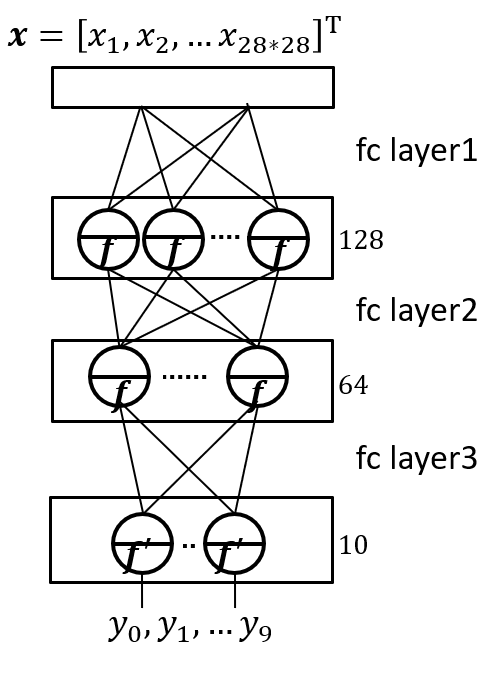

In [17]:
import matplotlib.pyplot as plt

# Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
# 0. 데이터 로드 & 전처리
transform = transforms.Compose([transforms.ToTensor()])
'''
ToTensor()의 기능
이미지를 PIL 이미지 또는 numpy 배열의 구조를 "Channel x Height x Width"로 바꾸고,
이미지 픽셀값 [0~225]를 [0~1]로 수정.
'''
train_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True,transform=transform)




In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset,shuffle=False)


In [31]:
# 1. 모델 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 16)  # 첫 번째 레이어
        self.fc2 = nn.Linear(16, 10)        # 세 번째 레이어 (출력층)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 입력 이미지를 1D 벡터로 변환
        # 첫 번째 레이어: ReLU
        x = torch.relu(self.fc1(x))
        # 두 번째 레이어: ReLU
        # 세 번째 레이어 (출력층): Softmax는 CrossEntropyLoss에 내장되어 있으므로 사용하지 않음
        x = self.fc2(x)
        return x


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [33]:
from torchsummary import summary
model = SimpleNN().to(device)
summary(model, (1, 28 * 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          12,560
            Linear-2                   [-1, 10]             170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [34]:
# 2. 모델 하이퍼 파라미터 설정 - 손실 함수 및 옵티마이저 정의 (cross entropy, Adam 사용)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [35]:
# 3. 모델 학습
for epoch in range(5):  # 5 epoch 학습
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device) # 데이터를 device로 이동
        # 옵티마이저 초기화
        optimizer.zero_grad()
        # 모델에 입력 데이터를 전달
        output = model(data)
        # 손실 계산
        loss = criterion(output, target)
        # 역전파
        loss.backward()
        # 모델 파라미터(업데이트)
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.2631084620952606
Epoch 2, Loss: 0.37286484241485596
Epoch 3, Loss: 0.27633073925971985
Epoch 4, Loss: 0.1956784725189209
Epoch 5, Loss: 0.4066220223903656


In [36]:
# 4. 결과예측
def test_model(model, test_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 전환 (Dropout이나 BatchNorm 비활성화)

    test_loss_list = []
    acc_list = []
    with torch.no_grad():  # 테스트 시에는 기울기를 계산하지 않으므로 메모리 최적화
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)# 데이터를 모델과 동일한 디바이스로 이동
            output = model(data)# 모델에 입력 데이터 전달
            # 손실 계산
            test_loss_list.append(criterion(output, target).item())
            # 예측 결과와 실제 정답 비교
            pred = output.argmax(dim=1, keepdim=True)  # 가장 높은 값의 인덱스를 예측으로 사용
            acc_list.append(pred.eq(target.view_as(pred)).sum().item())
    # 평균 손실 및 정확도 출력
    test_loss = sum(test_loss_list) / len(test_loader.dataset)
    accuracy = 100. * sum(acc_list)  / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return test_loss_list, acc_list


In [37]:
test_loss_list, acc_list=test_model(model, test_loader, criterion, device)

Test Loss: 0.2538, Accuracy: 92.69/10000 (92.69%)


# Pytorch tuning list
1. Activation layers
  - torch.relu, torch.sigmoid, torch.tanh, torch.PReLU, 등 지원

2. Optimizaer
  - optim.Adam 외에도 (optim.Adadelta, optim.AdamW, optim.SGD, optim.RMSprop 등 지원함)  
  (ex)
  ```
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  ```

3. Mini-batch Training
  - DataLoader에서 배치 크기를 조정

4. Weight initialization
  - torch.nn.init을 사용해서 초기화 사용자 함수(init_weights) 작성
  - model.apply(init_weights)로 적용
  - default: He Normal (from torch 2.1)
  (ex)
  ```
  def init_weights(m):
      if isinstance(m, nn.Linear):
          nn.init.xavier_uniform_(m.weight)  # Xavier 초기화 적용
          nn.init.constant_(m.bias, 0)       # 바이어스는 0으로 초기화
  model = SimpleNN()
  model.apply(init_weights)        
  ```
  
5. Batch Normalization
  - 각 레이어 사이에 nn.BatchNorm1d 입력해서 배치 정규화 추가
  (ex)  
  ```
  self.bn2 = nn.BatchNorm1d(64)
  ```

6. Regularization
  - L2 - reg: lambda = optimizer에서 weight_decay값 조절
  - Dropout: nn.Dropout(비율) 로 조절(ex. nn.Dropout(0.5))

### [튜닝 적용 예시]


```
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # 첫 번째 레이어 (28*28 input -> 128 hidden units)
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) # Batch Normalization
        self.dropout1 = nn.Dropout(0.5)  # 드롭아웃 추가 (50%)
        
        # 두 번째 레이어 (128 hidden units -> 64 hidden units)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) # Batch Normalization
        self.dropout2 = nn.Dropout(0.5)  # 드롭아웃 추가 (50%)
        
        # 세 번째 레이어 (64 hidden units -> 10 output units)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 첫 번째 레이어: ReLU활성화 + BatchNorm + Dropout
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        # 두 번째 레이어: ReLU + BatchNorm + Dropout
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

model = SimpleNN()
model.apply(init_weights)  # 가중치 초기화 적용

## 손실 함수 및 옵티마이저 정의 (Adam 사용, L2 정규화 적용)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss는 Softmax 포함
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 정규화 (weight_decay)

```

# To Do list!
1. SimpleNN 모델의 정의
 - [128, 64, 10] fully connected layer를 구성한다.
 - 각 fclayer는 relu activation을 쓴다.

 - optimizer 는 adam 으로 학습률 0.001로 한다.
 - 배치사이즈는 128, 총 epoch는 10으로 한다.
 - Xavier 초기화로 가중치를 초기화 한다.
 - 레이어 중간마다 batch normalization을 진행한다.
 - 첫번째와 두번째 layer는 드롭아웃(0.5)를 추가한다.
 - l2정규화를 0.01로 설정한다.

2. 학습수행 (train acc, loss 확인)
3. test acc, loss 확인


In [11]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [12]:
# 모델 정의 (SimpleNN)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        # 첫 번째 레이어 (128 units) + BatchNorm + Dropout(0.5)
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        # 두 번째 레이어 (64 units) + BatchNorm + Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)

        # 네 번째 레이어 (출력층 10 units)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 28x28 이미지를 1D 벡터로 변환

        # 첫 번째 레이어: ReLU + BatchNorm + Dropout
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        # 두 번째 레이어: ReLU + BatchNorm + Dropout
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        # 세 번째 레이어: 출력층
        x = self.fc3(x)
        return x

# 가중치 초기화 함수 (Xavier 초기화)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [13]:
# 모델 초기화 및 가중치 초기화 적용
from torchsummary import summary
model = SimpleNN().to(device)
model.apply(init_weights)
summary(model, (1, 28 * 28), device=str(device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
       BatchNorm1d-2                  [-1, 128]             256
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [14]:
# 손실 함수 및 옵티마이저 정의 (Adam, L2 정규화 포함)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # L2 정규화 (weight_decay=0.01)


In [15]:
# 학습
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # 1. 옵티마이저 초기화
        optimizer.zero_grad()

        # 2. 모델에 입력 데이터를 전달하고 손실 계산
        output = model(data)
        loss = criterion(output, target)

        # 3. 역전파 및 최적화
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.7988
Epoch [2/10], Loss: 0.4577
Epoch [3/10], Loss: 0.4088
Epoch [4/10], Loss: 0.3841
Epoch [5/10], Loss: 0.3726
Epoch [6/10], Loss: 0.3701
Epoch [7/10], Loss: 0.3666
Epoch [8/10], Loss: 0.3651
Epoch [9/10], Loss: 0.3665
Epoch [10/10], Loss: 0.3647


In [16]:
test_loss_list, acc_list=test_model(model, test_loader, criterion, device)


Test Loss: 0.1755, Accuracy: 95.82/10000 (95.82%)
